## Sentiment Analysis on Finance Data

In [80]:
#import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
from num2words import num2words
import unidecode
import re
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import naive_bayes
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import pickle

In [81]:
# Import the dataset
data=pd.read_csv('Finance data.csv')
data.head(10)

,Unnamed: 0,Sentence,Sentiment
0,0,The GeoSolutions technology will leverage Bene...,positive
1,1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,2,"For the last quarter of 2010 , Componenta 's n...",positive
3,3,According to the Finnish-Russian Chamber of Co...,neutral
4,4,The Swedish buyout firm has sold its remaining...,neutral
5,5,$SPY wouldn't be surprised to see a green close,positive
6,6,Shell's $70 Billion BG Deal Meets Shareholder ...,negative
7,7,SSH COMMUNICATIONS SECURITY CORP STOCK EXCHANG...,negative
8,8,Kone 's net sales rose by some 14 % year-on-ye...,positive
9,9,The Stockmann department store will have a tot...,neutral


In [22]:
print(data.dtypes)

Unnamed: 0     int64
Sentence      object
Sentiment     object
dtype: object


In [23]:
print(data.shape)

(5842, 3)


In [24]:
print(data.isnull().sum())

Unnamed: 0    0
Sentence      0
Sentiment     0
dtype: int64


In [25]:
print(data.isna().sum())

Unnamed: 0    0
Sentence      0
Sentiment     0
dtype: int64


In [26]:
print(data['Sentiment'].nunique())

3


In [27]:
print(data['Sentiment'].unique())

['positive' 'negative' 'neutral']


In [28]:
dic={'positive':0,'negative':0,'neutral':0}
for i in data['Sentiment']:
    dic[i]=dic[i]+1

In [29]:
print(dic)

{'positive': 1852, 'negative': 860, 'neutral': 3130}


In [30]:
n=len(data)
for i in data['Sentiment'].unique():
    print(i, round((dic[i]/n)*100,2))

positive 31.7
negative 14.72
neutral 53.58


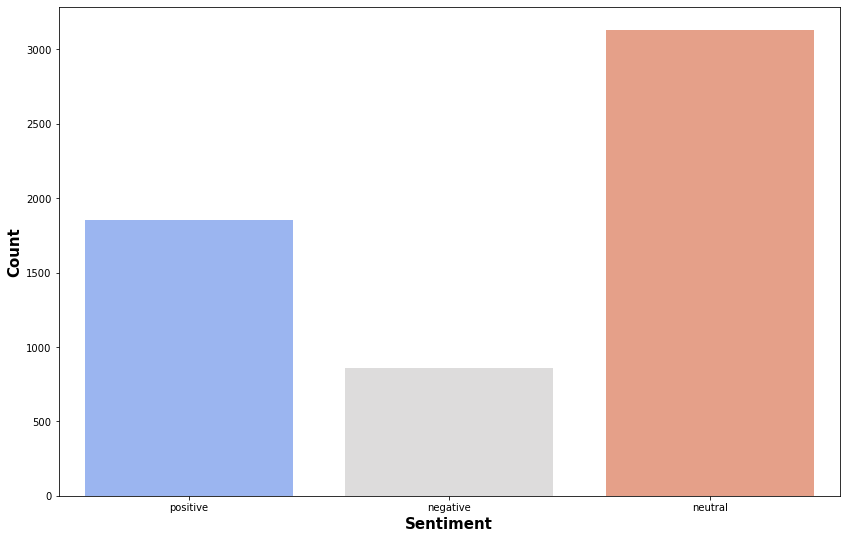

In [31]:
plt.figure(figsize=(14,9))
sns.countplot(x = 'Sentiment',data=data,palette ='coolwarm')
plt.xlabel("Sentiment",fontweight='bold',size=15)
plt.ylabel("Count",fontweight='bold',size=15)
plt.show()

In [82]:
# Converting into lower case

def convert_lowercase(sent):
    sent=sent.lower()
    return sent

In [33]:
data['Sentence']=data['Sentence'].apply(convert_lowercase)

In [83]:
#Removing punctuations in text column

def remove_punctuation(sen):
    for punctuations in string.punctuation:
        sen=sen.replace(punctuations,'')
    return sen

In [35]:
data['Sentence']=data['Sentence'].apply(remove_punctuation)

In [84]:
#Convert Number to Words

def num_to_words(text):
    # splitting text into words with space
    after_spliting = text.split()

    for index in range(len(after_spliting)):
        if after_spliting[index].isdigit():
            after_spliting[index] = num2words(after_spliting[index])

    # joining list into string with space
    numbers_to_words = ' '.join(after_spliting)
    return numbers_to_words

In [37]:
data['Sentence']=data['Sentence'].apply(num_to_words)

In [86]:
# Again removing punctuation due to applying number to word function, It may contain '-' between words

data['Sentence']=data['Sentence'].apply(remove_punctuation)

In [39]:
data.head(10)

,Unnamed: 0,Sentence,Sentiment
0,0,the geosolutions technology will leverage bene...,positive
1,1,esi on lows down one hundred and fifty to two ...,negative
2,2,for the last quarter of two thousand and ten c...,positive
3,3,according to the finnishrussian chamber of com...,neutral
4,4,the swedish buyout firm has sold its remaining...,neutral
5,5,spy wouldnt be surprised to see a green close,positive
6,6,shells seventy billion bg deal meets sharehold...,negative
7,7,ssh communications security corp stock exchang...,negative
8,8,kone s net sales rose by some fourteen yearony...,positive
9,9,the stockmann department store will have a tot...,neutral


In [87]:
#Convert Accented Characters to ASCII Characters

def to_ascii(x):
    x = unidecode.unidecode(x)
    return x


In [41]:
data['Sentence']=data['Sentence'].apply(to_ascii)

In [88]:
#Convert sms language into correct words

short_form_list = open('slang.txt', 'r')
chat_words_str = short_form_list.read()

chat_words_map_dict = []
chat_words_list = []
for line in chat_words_str.split("\n"):
    if line != " ":
        s=line.split('=')
        chat_words_map_dict.append(s)
        chat_words_list.append(s[0])
        

In [46]:
def short_to_original(text):

    new_text = []
    for w in text.split():
        if w.upper() in chat_words_list:
            for i in chat_words_map_dict:
                if i[0]==w.upper():
                    new_text.append(i[1])
        else:
            new_text.append(w)
    return " ".join(new_text)

In [89]:
# Removing Stopwords from Text

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Susma\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [48]:
data['Sentence'] = data['Sentence'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [90]:
# Lemmetizing the text

lemma = WordNetLemmatizer()
def lemmatization(Sentence):

    # word tokenization
    tokens = word_tokenize(Sentence)

    for index in range(len(tokens)):
        # lemma word
        lemma_word = lemma.lemmatize(tokens[index])
        tokens[index] = lemma_word

    return ' '.join(tokens)

In [91]:
# initialize lemmatizer object

import nltk
nltk.download('punkt')
nltk.download('wordnet')
data['Sentence']=data['Sentence'].apply(lemmatization)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Susma\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Susma\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


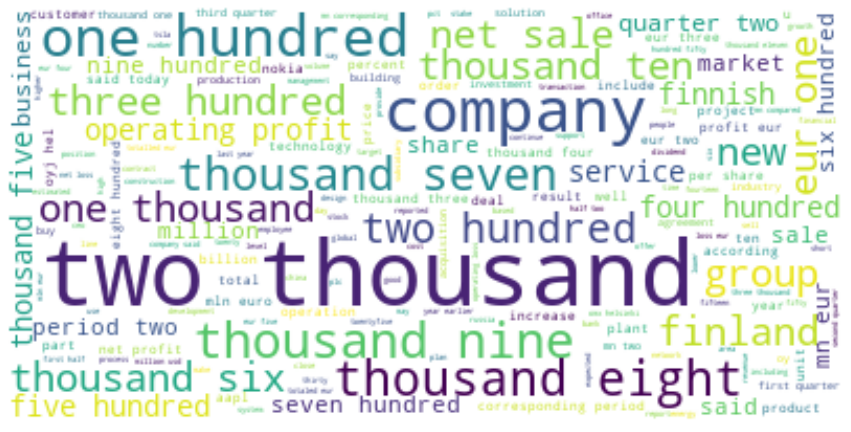

In [55]:
from wordcloud import WordCloud
from wordcloud import STOPWORDS
from wordcloud import ImageColorGenerator
text = " ".join(i for i in data.Sentence)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [92]:
#Tokenising to create bar plot with most frequent in each section and their frequency

from nltk import tokenize

token_space = tokenize.WhitespaceTokenizer()

def counter(text, column_text, quantity):
    all_words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                   "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'red')
    ax.set(ylabel = "Count")
    plt.xticks(rotation='vertical')
    plt.show()
  

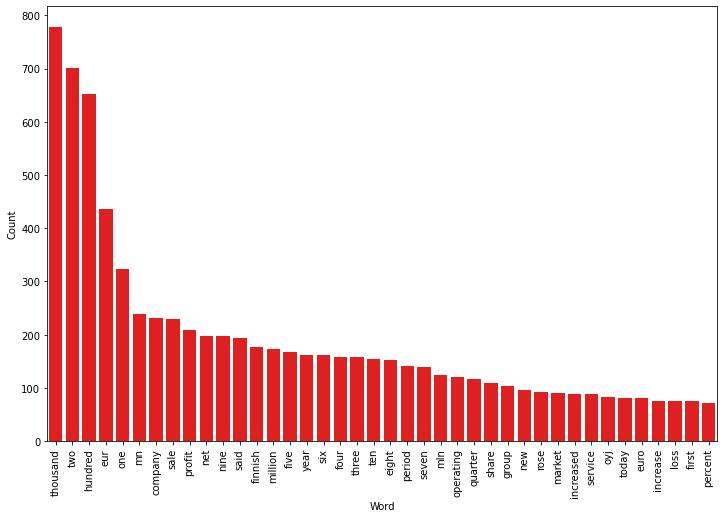

In [57]:
counter(data[data["Sentiment"] == "positive"], "Sentence", 40)


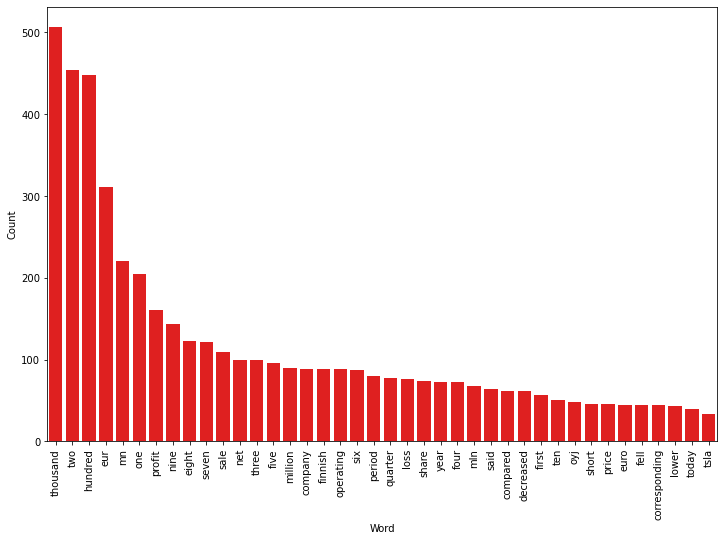

In [58]:
counter(data[data["Sentiment"] == "negative"], "Sentence", 40)

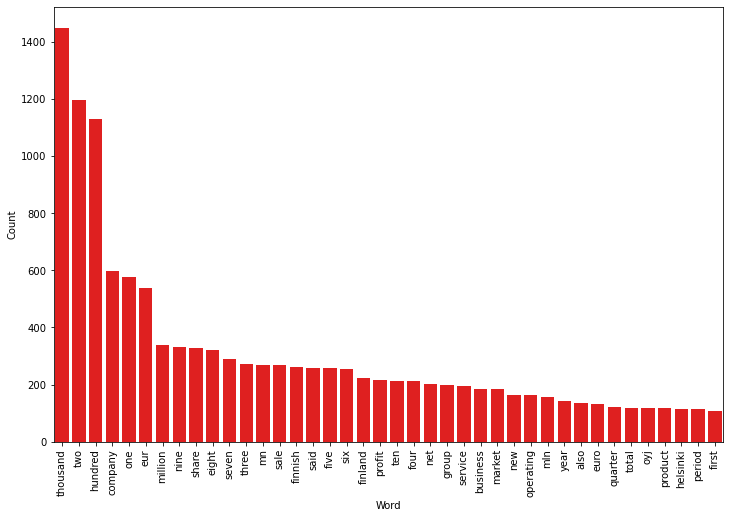

In [59]:
counter(data[data["Sentiment"] == "neutral"], "Sentence", 40)

In [93]:
#Apply LabelEnconding

def LABEL_ENCODING(c1):
    from sklearn import preprocessing
    label_encoder = preprocessing.LabelEncoder()
    data[c1]= label_encoder.fit_transform(data[c1])
    data[c1].unique()
LABEL_ENCODING("Sentiment")
data

,Unnamed: 0,Sentence,Sentiment
0,0,The GeoSolutions technology will leverage Bene...,2
1,1,ESI on low down 150 to 250 BK a real possibility,0
2,2,For the last quarter of 2010 Componenta s net ...,2
3,3,According to the FinnishRussian Chamber of Com...,1
4,4,The Swedish buyout firm ha sold it remaining 2...,1
...,...,...,...
5837,5837,RISING cost have forced packaging producer Huh...,0
5838,5838,Nordic Walking wa first used a a summer traini...,1
5839,5839,According shipping company Viking Line the EU ...,1
5840,5840,In the building and home improvement trade sal...,1


In [94]:
#Train Test Split

X=data['Sentence']
y=data['Sentiment']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=101)

### TF-IDF Vectorizer to Convert a text into a Vector

In [100]:
tfidf_vectorizer=TfidfVectorizer(stop_words='english', max_df=0.7)
tfidf_train=tfidf_vectorizer.fit_transform(X_train) 
tfidf_test=tfidf_vectorizer.transform(X_test)
tfidf_train.shape,tfidf_test.shape

((4089, 9780), (1753, 9780))

In [98]:
# Creating Pickle file to store Vectorizer Model

Pkl_filename = "tfidf.pkl"  
pickle.dump(tfidf_vectorizer, open(Pkl_filename, 'wb'))

### Naive Bayes Classifier

In [101]:
model_naive = naive_bayes.MultinomialNB()
model_naive.fit(tfidf_train, y_train)
prediction=model_naive.predict(tfidf_test)

In [69]:
print("Accuaracy Percentage ",round(accuracy_score(prediction,y_test),2))

Accuaracy Percentage  0.65


In [70]:
print(classification_report(prediction, y_test))

              precision    recall  f1-score   support

           0       0.05      0.87      0.09        15
           1       0.97      0.63      0.76      1443
           2       0.40      0.74      0.52       295

    accuracy                           0.65      1753
   macro avg       0.47      0.74      0.46      1753
weighted avg       0.87      0.65      0.72      1753



In [71]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm=confusion_matrix(y_test,prediction)
print(cm)

[[ 13 212  50]
 [  1 909  28]
 [  1 322 217]]


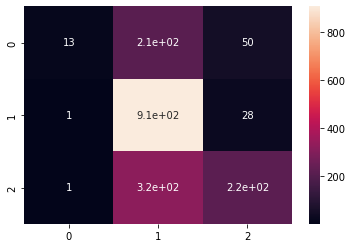

In [72]:
sns.heatmap(cm,annot =True)
plt.show()

### MultinomialNB Algorithm

In [102]:
from sklearn.naive_bayes import MultinomialNB
classifier=MultinomialNB()

classifier.fit(tfidf_train,y_train)
prediction_2=classifier.predict(tfidf_test)

In [74]:
print("Accuaracy Percentage ",round(accuracy_score(prediction_2,y_test),2))

Accuaracy Percentage  0.65


In [75]:
print(classification_report(prediction_2, y_test))

              precision    recall  f1-score   support

           0       0.05      0.87      0.09        15
           1       0.97      0.63      0.76      1443
           2       0.40      0.74      0.52       295

    accuracy                           0.65      1753
   macro avg       0.47      0.74      0.46      1753
weighted avg       0.87      0.65      0.72      1753



In [77]:
from sklearn.metrics import confusion_matrix, accuracy_score
con_mat=confusion_matrix(y_test,prediction_2)
print(con_mat)

[[ 13 212  50]
 [  1 909  28]
 [  1 322 217]]


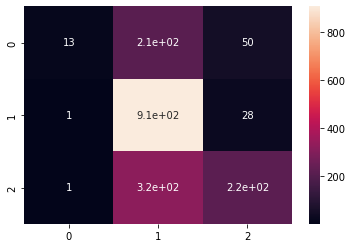

In [78]:
sns.heatmap(con_mat,annot =True)
plt.show()

In [79]:
#Pickling model
Pkl_Filename = "naive.pkl"  
pickle.dump(model_naive, open(Pkl_Filename, 'wb'))